<a href="https://colab.research.google.com/github/dots13/RohlikSalesForecastingChallengeKaggle/blob/main/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok --quiet

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/kaggle/rohlic/mlflow_logs /content/

In [ ]:
!pip install mlflow

In [ ]:
import pandas as pd
import numpy as np
from pyngrok import ngrok

import mlflow
import mlflow.catboost
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb

In [ ]:
!ls drive/MyDrive/kaggle/rohlic/data

df_pred.csv	       df_sales_test_all_final.csv  df_sales_train_all_final.csv
df_sales_test_all.csv  df_sales_train_all.csv


In [ ]:
df_train = pd.read_csv('drive/MyDrive/kaggle/rohlic/data/df_sales_train_all_final.csv')
df_test = pd.read_csv('drive/MyDrive/kaggle/rohlic/data/df_sales_test_all_final.csv')

In [ ]:
df_train.shape

In [ ]:
df_train = df_train.sort_values(by=['warehouse', 'name', 'date'])

# Handle Missing Values

In [ ]:
df_train["sales"] = df_train.groupby(["warehouse", "unique_id"])["sales"].transform(lambda x: x.fillna(x.rolling(3, min_periods=1).mean()))
df_train["sales"] = df_train.groupby(["warehouse", "unique_id"])["sales"].ffill()
df_train.isna().sum()

# Feature engineering

In [ ]:
# Function to Add Time-Based Features
def add_time_features(df):
    """
    Adds time-based features to a DataFrame with a 'date' column.

    Args:
    df (pd.DataFrame): Input DataFrame containing a 'date' column.

    Returns:
    pd.DataFrame: DataFrame with added time-based features.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])  # Ensure date format

    # Basic date features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_year"] = df["date"].dt.dayofyear
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["quarter"] = df["date"].dt.quarter

    # Cyclical encoding for time-based features
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    df["day_of_week_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7.0)
    df["day_of_week_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7.0)
    df["day_of_year_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.0)
    df["day_of_year_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.0)
    df["week_of_year_sin"] = np.sin(2 * np.pi * df["week_of_year"] / 52.0)
    df["week_of_year_cos"] = np.cos(2 * np.pi * df["week_of_year"] / 52.0)

    # Additional time cycles
    df["half_year_sin"] = np.sin(2 * np.pi * df["month"] / 6)
    df["half_year_cos"] = np.cos(2 * np.pi * df["month"] / 6)
    df["two_year_sin"] = np.sin(2 * np.pi * df["year"] / 2)
    df["two_year_cos"] = np.cos(2 * np.pi * df["year"] / 2)

    df["max_discount"] = df[
    ["type_0_discount", "type_1_discount", "type_2_discount", "type_3_discount", "type_4_discount", "type_5_discount", "type_6_discount"]
    ].max(axis=1)

    return df


In [ ]:
# Function to Add Shifting and Rolling Features
def add_feature_shifts(df):
    """
    Adds shifting and rolling features for sales and price data.

    Args:
    df (pd.DataFrame): Input DataFrame containing 'sales' and 'sell_price_main' columns.

    Returns:
    pd.DataFrame: DataFrame with added lag, rolling, and additional features.
    """
    df = df.copy()

    # Lag Features
    df['sales_lag_1'] = df.groupby(['warehouse', 'name'])['sales'].shift(1)
    df['sales_lag_7'] = df.groupby(['warehouse', 'name'])['sales'].shift(7)
    df['sales_lag_30'] = df.groupby(['warehouse', 'name'])['sales'].shift(30)

    # Rolling Features
    df['sales_rolling_mean_7'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean()).shift(1)
    df['sales_rolling_std_7'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).std()).shift(1)
    df['sales_rolling_mean_14'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.rolling(14, min_periods=1).mean()).shift(1)
    df['sales_rolling_std_14'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.rolling(14, min_periods=1).std()).shift(1)
    df['sales_rolling_mean_30'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean()).shift(1)
    df['sales_rolling_std_30'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).std()).shift(1)

    # Exponentially Weighted Mean
    df['sales_exp_weighted_3'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.ewm(span=3, adjust=False).mean()).shift(1)
    df['sales_exp_weighted_7'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.ewm(span=7, adjust=False).mean()).shift(1)
    df['sales_exp_weighted_14'] = df.groupby(['warehouse', 'name'])['sales'].transform(lambda x: x.ewm(span=14, adjust=False).mean()).shift(1)

    # Week-over-Week Change
    df['sales_wow_change'] = (df['sales'] / df.groupby(['warehouse', 'name'])['sales'].shift(7) - 1).shift(1)

    # Price Elasticity
    df['price_change_1'] = df.groupby(['warehouse', 'name'])['sell_price_main'].pct_change()
    df['price_change_7'] = df.groupby(['warehouse', 'name'])['sell_price_main'].pct_change(periods=7)

    # Trend Feature
    df['sales_trend_7_14'] = df['sales_rolling_mean_7'] - df['sales_rolling_mean_14']
    df['sales_trend_14_30'] = df['sales_rolling_mean_14'] - df['sales_rolling_mean_30']

    # Shift the trend features
    df['sales_trend_7_14'] = df['sales_trend_7_14'].shift(1)
    df['sales_trend_14_30'] = df['sales_trend_14_30'].shift(1)

    return df

In [ ]:
train = add_time_features(df_train)
train = add_feature_shifts(train)
#del df_train

In [ ]:
categorical_features = [
    'warehouse',
    'holiday',
    'shops_closed',
    'school_holiday_custom',
    'name'
]

numerical_features = [
    'total_orders',
    'sell_price_main',
    'max_discount',
    'year',
    'month',
    'day_of_week',
    'day_of_year',
    'week_of_year',
    'is_weekend',
    'quarter',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_of_year_sin',
    'day_of_year_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'half_year_sin',
    'half_year_cos',
    'two_year_sin',
    'two_year_cos',
    'sales_lag_1',
    'sales_lag_7',
    'sales_lag_30',
    'sales_rolling_mean_7',
    'sales_rolling_std_7',
    'sales_rolling_mean_14',
    'sales_rolling_std_14',
    'sales_rolling_mean_30',
    'sales_rolling_std_30',
    'sales_exp_weighted_3',
    'sales_exp_weighted_7',
    'sales_exp_weighted_14',
    'sales_wow_change',
    'price_change_1',
    'price_change_7',
    'sales_trend_7_14',
    'sales_trend_14_30'
]

In [ ]:
def weighted_mae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [ ]:
mlflow.set_tracking_uri("file:///content/mlflow_logs")
mlflow.set_experiment("CatBoost_Baseline")

# Split data

In [ ]:
unique_dates = sorted(train['date'].unique())
split_date = unique_dates[int(0.82 * len(unique_dates))]
print(split_date)
train_set = train[train['date'] <= split_date]
test_set = train[train['date'] > split_date]
print(len(train_set)/len(train))

features = numerical_features + categorical_features
target = "sales"

X_train, y_train, w_train = train_set[features], train_set[target], train_set["weight"]
X_test, y_test, w_test = test_set[features], test_set[target], test_set["weight"]

train_pool = Pool(X_train, label=y_train, cat_features=[features.index(f) for f in categorical_features])
test_pool = Pool(X_test, label=y_test, cat_features=[features.index(f) for f in categorical_features])

In [ ]:
with mlflow.start_run(run_name="MLflow on Colab 14"):
    # Train CatBoost Model
    model_100 = CatBoostRegressor(iterations=100,
                              depth=7,
                              learning_rate=0.1,
                              loss_function='MAE',
                              verbose=100
                              )

    model_100.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

    # Predictions
    preds = model_100.predict(X_test)
    wmae = weighted_mae(y_test, preds, w_test)

    # Define model signature
    #signature = mlflow.model_100.infer_signature(X_test, preds)

    # Log Parameters & Metrics
    mlflow.log_param("iterations", 100)
    mlflow.log_param("depth", 6)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_metric("WMAE", wmae)

    # Log Model
    mlflow.catboost.log_model(model_100, "catboost_model", signature=signature)

    print(f"Model logged with WMAE: {wmae}")

0:	learn: 85.8697669	test: 85.3193833	best: 85.3193833 (0)	total: 3.9s	remaining: 6m 25s
99:	learn: 25.5468900	test: 37.7546464	best: 29.1431174 (83)	total: 4m 18s	remaining: 0us

bestTest = 29.1431174
bestIteration = 83

Shrink model to first 84 iterations.


AttributeError: module 'mlflow' has no attribute 'model_100'

# Iterative forecast

In [ ]:
df_test.isna().sum()

,0
unique_id,0
date,0
warehouse,0
total_orders,0
sell_price_main,0
type_0_discount,0
type_1_discount,0
type_2_discount,0
type_3_discount,0
type_4_discount,0


In [ ]:
def iterative_forecast_with_history(model, train_df, test_df, features, categorical_features):
    test_df = test_df.copy()
    train_df["date"] = pd.to_datetime(train_df["date"])
    test_df["date"] = pd.to_datetime(test_df["date"])

    # Sort by warehouse, name, and date
    train_df = train_df.sort_values(by=['warehouse', 'name', 'date'])
    test_df = test_df.sort_values(by=['warehouse', 'name', 'date'])

    predictions = []
    result = []  # Store the result (id, date, prediction)

    # Get the last 30 rows for each group to initialize
    last_30_days = train_df.groupby(['warehouse', 'name']).tail(30)
    extended_test_df = pd.concat([last_30_days, test_df], ignore_index=True)
    extended_test_df['date'] = pd.to_datetime(extended_test_df['date'])

    # Iterate over the extended test set to make predictions
    for i in range(len(last_30_days), len(extended_test_df)):
        if (i - len(last_30_days)) % 500 == 0:
            print(f"Processing row {i - len(last_30_days)}")

        row = extended_test_df.iloc[i].copy()
        row['date'] = pd.to_datetime(row['date'])
        # Group-specific feature engineering (based on warehouse and name)
        group_data = extended_test_df[(extended_test_df['warehouse'] == row['warehouse']) &
                                      (extended_test_df['name'] == row['name']) &
                                      (extended_test_df['date'] <= row['date'])]
        group_data.reset_index(drop=True, inplace=True)
        row_df = pd.DataFrame([row])


        # Add general time features
        group_data = add_time_features(group_data)

        # Add shifting and rolling features
        #non_nan_idx = group_data[group_data['sales'].isna()].index[0]  # Get the index of non-NaN sales
        row_df = add_feature_shifts(group_data)
        last_row = row_df[row_df["date"] == row["date"]]
        #print(last_row)

        # Prepare the Pool for CatBoost prediction
        row_pool = Pool(
            last_row[features],
            cat_features=[features.index(f) for f in categorical_features]
        )

        # Make the prediction
        pred = model.predict(row_pool)[0]
        predictions.append(pred)

        # Store the result (id, date, prediction)
        result.append({
            "id": str(row['unique_id']) + '_' + row["date"].strftime('%Y-%m-%d'),
            'prediction': pred
        })

        # Update the extended_test_df with the prediction (optional, can be used for further analysis)
        extended_test_df.at[i, "sales"] = pred

    result_df = pd.DataFrame(result)
    return result_df

In [ ]:
df_pred = iterative_forecast_with_history(model_100, df_train, df_test, features, categorical_features)

<ipython-input-28-001a4b74e248>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last_30_days = train_df.groupby(['warehouse', 'name']).tail(30)


Processing row 0


KeyboardInterrupt: 

In [ ]:
!cp -r df_pred_5.csv drive/MyDrive/kaggle/rohlic

In [ ]:
df_submission = df_test[['unique_id', 'date']]

In [ ]:
df_submission['id'] = (df_submission['unique_id']).astype(str) + '_' + (df_submission['date']).astype(str)

<ipython-input-41-6cc4bc54e387>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['id'] = (df_submission['unique_id']).astype(str) + '_' + (df_submission['date']).astype(str)


In [ ]:
df_sub = pd.merge(df_pred, df_submission, on='id')[['id', 'prediction']]
df_sub.columns = ['id', 'sales_hat']
df_sub.set_index("id", inplace=True)
df_sub.to_csv("submission_06.csv")

In [ ]:
!cp -r submission_05.csv drive/MyDrive/kaggle/rohlic

In [ ]:
# Start MLflow UI with the correct backend store
get_ipython().system_raw("mlflow ui --backend-store-uri file:///content/mlflow_logs --port 5000 &")

from pyngrok import ngrok
import time

# Kill all existing ngrok processes to avoid conflicts
ngrok.kill()
time.sleep(2)  # Add a short delay to ensure cleanup

# Set Ngrok auth token (optional)
NGROK_AUTH_TOKEN = "2sp7h4LGTvJrClc5vWHLzYHk3QN_6xUDvEZVVk26CTHkspWgm"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPS tunnel on port 5000 for MLflow UI
try:
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)
except Exception as e:
    print(f"Error starting ngrok: {e}")


MLflow Tracking UI: https://4ee2-34-106-218-112.ngrok-free.app


In [ ]:
if mlflow.active_run():
    mlflow.end_run()

kaggle_public_score = 27.35697
with mlflow.start_run(run_id='a71d5856ef0343a8b5f9daef499bb54d'):
    mlflow.log_metric("Kaggle_Public_Score", kaggle_public_score)

In [ ]:
!cp -r mlflow_logs drive/MyDrive/kaggle/rohlic

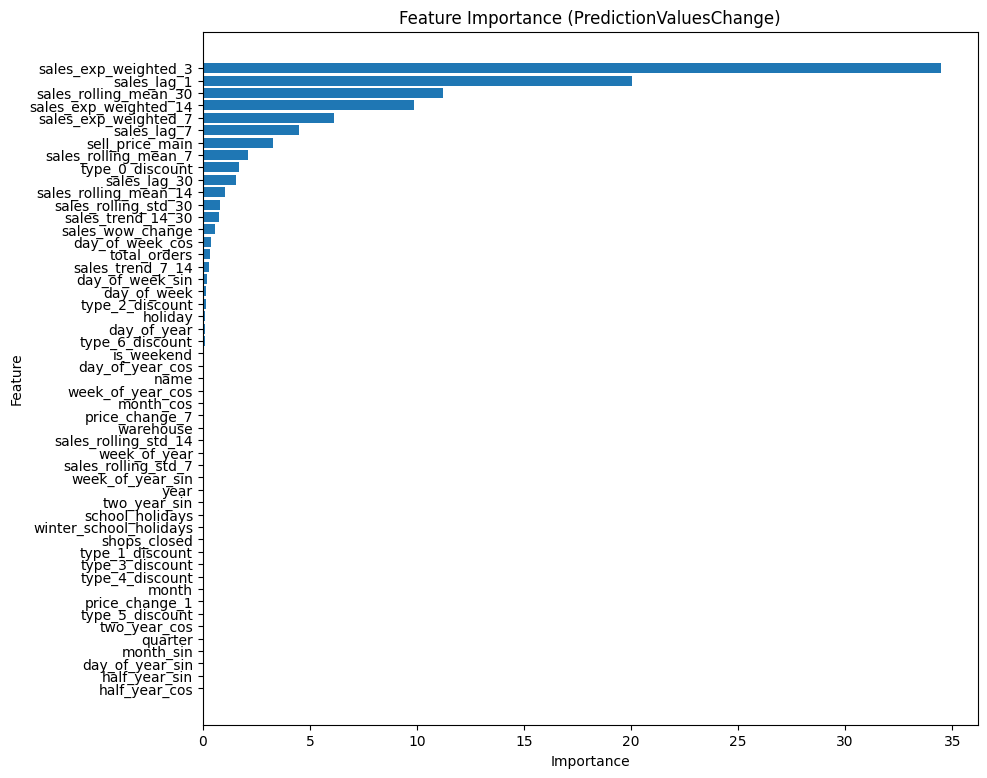

In [ ]:
feature_importance = model.get_feature_importance()
feature_names = model.feature_names_

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,9))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (PredictionValuesChange)')
plt.gca().invert_yaxis()
plt.show()
